In this Module, we will try to build a Baseline model for MNIST dataset with 90+ accuracy. During the journey, we will also get used to the pytorch tensors and learn how they make deep learning faster using GPU. We will also go through the concept of Broadcasting.

In [1]:
from fastai.vision.all import *
from fastbook import *
import numpy as np
matplotlib.rc('image', cmap='Greys')

# Dataset Information

**About MNIST_SAMPLE and Untar_data**

MNIST_SAMPLE has only 3s and 7s from MNIST.

In [2]:
URLs.MNIST_SAMPLE

'http://files.fast.ai/data/examples/mnist_sample.tgz'

"URLs.MNIST_SAMPLE" link is where the data is stored on cloud.

Calling untar_data on URLs.MNIST_SAMPLE does this:\
Untar_data checks if the dataset is already downloaded, if no then downloads it. Then checks if it is uncompressed already, if not uncompresses it. Then gives you the path to dataset on your system. Since, i have used the Fastai environment in Paperspace gradient, I can see all the datasets already in storage folder, So untar_data did not download. In my PC, by default data is stored in '/home/ashwani/.fastai/data/mnist_sample'


In [3]:
doc(untar_data)

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

path

Path('/storage/data/mnist_sample')

**Setting BasePath**

In [5]:
#without setting Basepath
path.ls()

(#3) [Path('/storage/data/mnist_sample/labels.csv'),Path('/storage/data/mnist_sample/valid'),Path('/storage/data/mnist_sample/train')]

In [6]:
Path.BASE_PATH = path

In [7]:
#After setting Basepath
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

**About Fastcore**

path is actually a python standard path object(pathlib.PosixPath). But this standard library doesn't have ls() function, whenever such scenario comes, i.e. required functionalities are not present in standard libraries, Fastai has a library called Fastcore which adds that functionality there. 

try path.ls?, path.ls?? to get source and the source code

In [8]:
type(path)
path.ls?
# File:      /opt/conda/envs/fastai/lib/python3.8/site-packages/fastcore/utils.py

path.ls??
# source code

**About the General Dataset storage heirarchy in Deep Learning**

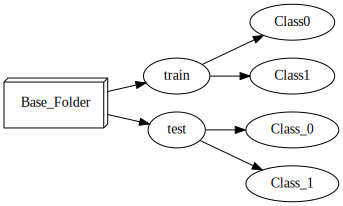

In [9]:
gv('''Base_Folder[shape=box3d width=1 height=0.7]
Base_Folder->train->Class0; Base_Folder->test;train->Class1;test->Class_0;test->Class_1''')

In [10]:
print(path.ls())
print((path/'train').ls())
print((path/'valid').ls())

(#3) [Path('labels.csv'),Path('valid'),Path('train')]
(#2) [Path('train/7'),Path('train/3')]
(#2) [Path('valid/7'),Path('valid/3')]


# Get Data

In [11]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [12]:
im_path = threes[0]
image = Image.open(im_path)
image

In [13]:
type(image)

PIL.PngImagePlugin.PngImageFile

PIL is the most popular python imaging library. It's a Png Image, because of .png extension. Lets convert this image to array of numbers

**Arrays Vs Tensors**

In [ ]:
np.array(image)
#array(image) also works, after importing fastbook, a lot of basic python packages need not be imported.

A tensor is the pytorch analogue for a numpy array. It works exactly like an array, with slicing etc similar to array. Tensors do run on GPU also, that's why they are preferred over array, which only run on CPU.

In [15]:
tensor(image)[5:20,5:20]

tensor([[  0,   0,   0,   0,   0, 103, 242, 254, 254, 254, 254, 254,  66,   0,   0],
        [  0,   0,   0,   0,   0,  18, 232, 254, 254, 254, 254, 254, 238,  70,   0],
        [  0,   0,   0,   0,   0,   0, 104, 244, 254, 224, 254, 254, 254, 141,   0],
        [  0,   0,   0,   0,   0,   0,   0, 207, 254, 210, 254, 254, 254,  34,   0],
        [  0,   0,   0,   0,   0,   0,   0,  84, 206, 254, 254, 254, 254,  41,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,  24, 209, 254, 254, 254, 171,   0],
        [  0,   0,   0,   0,   0,   0,   0,  91, 137, 253, 254, 254, 254, 112,   0],
        [  0,   0,   0,   0,   0,  40, 214, 250, 254, 254, 254, 254, 254,  34,   0],
        [  0,   0,   0,   0,   0,  81, 247, 254, 254, 254, 254, 254, 254, 146,   0],
        [  0,   0,   0,   0,   0,   0, 110, 246, 254, 254, 254, 254, 254, 171,   0],
        [  0,   0,   0,   0,   0,   0,   0,  73,  89,  89,  93, 240, 254, 171,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1, 1

**Using Dataframe - Background gradient argument**

In [16]:
im3_t = tensor(image)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,42,118,219,166,118,118,6,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,103,242,254,254,254,254,254,66,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,18,232,254,254,254,254,254,238,70,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,104,244,254,224,254,254,254,141,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,207,254,210,254,254,254,34,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,84,206,254,254,254,254,41,0,0,0,0,0,0,0,0,0


# Baseline Model: Pixel Similarity

Let's find the pixel average value of each pixel over all the "3" entries. This would give us a 28 x 28 image of an ideal 3.
Similarly we will do for 7, and then compare each of our test entries to these ideal 3 and 7.

**List Comprehension**

make a list of all the 3 entry tensors

In [17]:

three_list = [tensor(Image.open(o)) for o in threes]
seven_list = [tensor(Image.open(o)) for o in sevens]

In [18]:
print('No. of entries: {}'.format(len(three_list)))
print('tensor shape: [{}, {}, {}]'.format(len(three_list), len(three_list[0]), len(three_list[0][0])))

No. of entries: 6131
tensor shape: [6131, 28, 28]


**Finding Mean 3s and 7s**

In [19]:
#three_list1 = [array(Image.open(o)) for o in sevens]
#a = array(three_list1)
#type(a) woruld be numpy.ndarray 
stacked_threes = torch.stack(three_list).float()/255
stacked_sevens = torch.stack(seven_list).float()/255
print(type(stacked_threes),stacked_threes.shape)
print('Rank = {}'.format(stacked_threes.ndim))

<class 'torch.Tensor'> torch.Size([6131, 28, 28])
Rank = 3


if instead of tensors, we convert each entry to an array, then the list of arrays(three_list1) need not be stacked using torch.stack. One can directly convert a list of objects to array using np.array(list). Dividing by 255 is a standard for float representation in Computer vision.

dimension now = torch.Size([28, 28])


<AxesSubplot:>

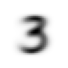

In [20]:
mean3 = stacked_threes.mean(0) #reduce the axis 0
print('dimension now = {}'.format(mean3.shape))
show_image(mean3)

dimension now = torch.Size([28, 28])


<AxesSubplot:>

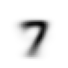

In [21]:
mean7 = stacked_sevens.mean(0) #reduce the axis 0
print('dimension now = {}'.format(mean7.shape))
show_image(mean7)

**Note**- A PIL object is displayed as an image by default in Jupyter. So symply typing object's name would do(like we did in case of image). But a tensor is displayed as a set of numbers if we directly type its name. So use **show_image(tensor_name)** instead.

**Comparing a random entry to the mean3 and mean7**

we can find its distance from the mean3 and mean7 using two ways, the mean absolute difference and the root mean squared error. We do this because we want to avoid the scenario where the total difference cancels out to be zero when we directly sum the difference of individual pixels.

<AxesSubplot:>

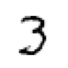

In [22]:
# take a random three
a_3 = three_list[32].float()/255
# a_3 = stacked_threes[32]
show_image(a_3)

**L1 Norm or mean absolute difference**

In [23]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_7_abs = (a_3 - mean7).abs().mean()
dist_3_abs, dist_7_abs

(tensor(0.1077), tensor(0.1443))

This can be directly done in fastai as shown below. You'll find these functionalities inside torch.nn.functional, which the PyTorch team recommends importing as F (and is available by default under that name in fastai):

In [24]:
F.l1_loss(a_3, mean3), F.l1_loss(a_3, mean7)

(tensor(0.1077), tensor(0.1443))

**L2 Norm or RMSE**

In [25]:
dist_3_sq = np.sqrt(((a_3 - mean3)**2).mean())
dist_7_sq = np.sqrt(((a_3 - mean7)**2).mean())
dist_3_sq, dist_7_sq

(tensor(0.1918), tensor(0.2794))

In [26]:
np.sqrt(F.mse_loss(a_3, mean3)), np.sqrt(F.mse_loss(a_3, mean7))

(tensor(0.1918), tensor(0.2794))

From L1 and L2 norms, it can be seen that the difference of a_3 is less with mean3. So, a_3 would be classified as 3. That was our baseline model.

# Arrays vs Tensors

**Numpy Array - Some important points from book.**
- Numpy arrays provide very similar functionality and a very similar API to that provided by PyTorch; however, it does not support using the GPU or calculating gradients, which are both critical for deep learning.
- Python is slow compared to many languages. Anything fast in Python, NumPy, or PyTorch is likely to be a wrapper for a compiled object written (and optimized) in another language—specifically C. In fact, NumPy arrays and PyTorch tensors can finish computations many thousands of times faster than using pure Python.
- A NumPy array is a multidimensional table of data, with all items of the same type. Since that can be any type at all, they can even be arrays of arrays, with the innermost arrays potentially being different sizes—this is called a "jagged array." By "multidimensional table" we mean, for instance, a list (dimension of one), a table or matrix (dimension of two), a "table of tables" or "cube" (dimension of three), and so forth. If the items are all of some simple type such as integer or float, then NumPy will store them as a compact C data structure in memory. This is where NumPy shines. NumPy has a wide variety of operators and methods that can run computations on these compact structures at the same speed as optimized C, because they are written in optimized C.
- A PyTorch tensor is nearly the same thing as a NumPy array, but with an additional restriction that unlocks some additional capabilities. It's the same in that it, too, is a multidimensional table of data, with all items of the same type. However, the restriction is that a tensor cannot use just any old type—it has to use a single basic numeric type for all components. For example, a PyTorch tensor cannot be jagged. It is always a regularly shaped multidimensional rectangular structure.

# Metric Measuring Accuracy of our baseline model

In [67]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

**Define a Function which finds the difference metric and another function which compares difference metric and returns True if the number in picture is 3**

In [68]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2)) # mean on last two dimns
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)
mnist_distance(a_3, mean3),is_3(a_3)

(tensor(0.1077), tensor(True))

### Broadcasting

In [69]:
print(tensor([1,2,3]) + tensor([1,1,1]))
array([1,2,3]) + array([1,1,1])

tensor([2, 3, 4])


array([2, 3, 4])

In [70]:
print(tensor([1,2,3]) + tensor([1]))
print(array([1,2,3]) + array([1]))

tensor([2, 3, 4])
[2 3 4]


In [71]:
#print(tensor([1,2,3]) + [1]) #this gives an error. TypeError: unsupported operand type(s) for +: 'Tensor' and 'list'
print(array([1,2,3]) + [1])

[2 3 4]


This is the additional restriction mentioned for tensors earlier. Tensor cannot use just any old type—it has to use a single basic numeric type for all components. For example, a PyTorch tensor cannot be jagged. It is always a regularly shaped multidimensional rectangular structure.

In [72]:
print(tensor([1,2,3]) + 1) #I have no idea why this works. 
print(array([1,2,3]) + 1)

tensor([2, 3, 4])
[2 3 4]


In [73]:
print(tensor([1,2,3],[4,5,6]) + tensor([1,1,1]))
print(tensor([1,2,3],[4,5,6]).shape)
print(tensor([[1,2,3],[4,5,6]]).shape) #tensor([],[]) = tensor([],[]) ??
array([[1,2,3],[4,5,6]]) + array([1,1,1]) # array([],[]) gives error

tensor([[2, 3, 4],
        [5, 6, 7]])
torch.Size([2, 3])
torch.Size([2, 3])


array([[2, 3, 4],
       [5, 6, 7]])

In [74]:
print(tensor([1,2,3],[4,5,6]) + tensor([1]))
array([[1,2,3],[4,5,6]]) + array([1])

tensor([[2, 3, 4],
        [5, 6, 7]])


array([[2, 3, 4],
       [5, 6, 7]])

In [75]:
# print(tensor([1,2,3],[4,5,6]) + [1]) # TypeError: unsupported operand type(s) for +: 'Tensor' and 'list'
array([[1,2,3],[4,5,6]]) + [1]

array([[2, 3, 4],
       [5, 6, 7]])

In [76]:
print(tensor([1,2,3],[4,5,6]) + 1)
array([[1,2,3],[4,5,6]]) + 1

tensor([[2, 3, 4],
        [5, 6, 7]])


array([[2, 3, 4],
       [5, 6, 7]])

### Okay!! Broadcasting is quite confusing :|

The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use broadcasting. That is, it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. Broadcasting is an important capability that makes tensor code much easier to write.

After broadcasting so the two argument tensors have the same rank, PyTorch applies its usual logic for two tensors of the same rank: it performs the operation on each corresponding element of the two tensors, and returns the tensor result.

## Broadcasting in our Model

In [77]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1290, 0.1223, 0.1380,  ..., 0.1337, 0.1132, 0.1097]),
 torch.Size([1010]))

In [82]:
res3 = is_3(valid_3_tens)
res3, res3.float(), res3.shape

(tensor([True, True, True,  ..., True, True, True]),
 tensor([1., 1., 1.,  ..., 1., 1., 1.]),
 torch.Size([1010]))

In [83]:
res7 = is_3(valid_7_tens)
res7, res7.float(), res7.shape

(tensor([False, False, False,  ..., False, False, False]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 torch.Size([1028]))

In [96]:
acc_3 = sum(res3).float()/res3.shape[0] #res3.float().mean()
acc_7 = 1 - sum(res7).float()/res7.shape[0]
print('The accuracy obtained for 3s and 7s are: {}, {}'.format(acc_3, acc_7))

The accuracy obtained for 3s and 7s are: 0.9168316721916199, 0.9854085445404053


**that's a pretty good baseline model!!**